# Overview

this notebook runs the models and save the time and score
the saved dataframe can be found in `../data/processed/results_{date}`

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
from src.graph import NetworkGraph

In [3]:
import time
import gurobi
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import math

In [4]:
from src.flows import *
from src.models.DQL.DQL import run

In [5]:
from flatland.envs.rail_env import RailEnv
from flatland.envs.observations import *
from flatland.envs.rail_generators import complex_rail_generator,rail_from_manual_specifications_generator,random_rail_generator, RailGenerator
from flatland.envs.schedule_generators import complex_schedule_generator, random_schedule_generator, ScheduleGenerator
from flatland.utils.rendertools import RenderTool

### Helper functions

In [6]:
def create_env(height,width,seed,number_of_agents=4):
    env = RailEnv(width=width,
              height=height,
              rail_generator=complex_rail_generator(nr_start_goal=20, nr_extra=1, 
                                                    min_dist=6, max_dist=99999, seed = seed),
              schedule_generator=complex_schedule_generator(),
              number_of_agents=number_of_agents)
    
    
    
    return env

In [7]:
def run_flow(env,height,width):
    
    #extract the transition matrix
    matrix_rail = np.array(env.rail.grid.tolist())
    
    #build the transition network
    flatlandNetwork = NetworkGraph(matrix_rail)

    #get the sources and sinks of the different agents
    sources = []
    sinks = []
    for agent in env.agents:
        sources.append(agent.initial_position)
        sinks.append(agent.target)
        
    #build the time exanded network and connect the sources and sinks
    TestNetworkTime = TimeNetwork(flatlandNetwork, depth=max(2*(height+width),40))
    TestNetworkTime.connect_sources_and_sink(sources,sinks)
    
    
    #get the Integral Program formulation of the problem and solve it 
    print(sources,sinks)
    mcflow = MCFlow(TestNetworkTime.graph,len(sources),TestNetworkTime.topology)
    mcflow.solve()
    
    #extract the path and compute the scores (total time spent by the agent in the grid)
    cost= 0
    if not mcflow.check_if_feasible():
        return "Infeasible"
    print(mcflow.m.objVal)
    paths = mcflow.extract_paths()
    for agent,path in paths.items():
        print(path)
        cost += -1+len(path)/2
       
    return cost

In [8]:
def run_flow_rl(env,width,height,seed,n_start_goal=20,initial_value = 0,
             learning_rate = 0.8,gamma = 0.9,epsilon = 0.1,threshold = 0.3):
    number_agents = len(env.agents)
    n_episodes = width*height*number_agents*15
    n_steps = 2*(width+height)
    print(seed)
    cost, n_episodes, total_time = run(number_agents,
                                    width,height,
                                    n_start_goal,
                                    seed,
                                    n_episodes,
                                    n_steps,
                                    initial_value,
                                    learning_rate,
                                    gamma,
                                    epsilon,
                                    threshold)
    
    return cost, n_episodes, total_time

In [14]:
def run_experiment_and_save_results(method, results,agents = 4, repetition = 5, 
                                    pathToSavedGrids = None, grids_size = None):
    nodes = []
    edges = []
    sizes_list = []
    if pathToSavedGrids is None:
        for sizes in tqdm(grids_size):
            for i in range(repetition):
                seed = sizes[0]*sizes[1]+i
                print(f'seed {seed}')
                env = create_env(sizes[0],sizes[1],seed,number_of_agents=agents)
                
                env.step({0:2})
                env_renderer = RenderTool(env,agent_render_variant=3)
                env_renderer.render_env(show=True, show_predictions=False, show_observations=False)
                env = create_env(sizes[0],sizes[1],seed,number_of_agents=agents)
    
                start = time.time()
                cost = run_flow(env,sizes[0],sizes[1])
                print(cost)
                sizes_list.append(sizes[0]*sizes[1])                    
                time_spent = time.time()-start
                results = results.append({'Size of the grid' : sizes[0]*sizes[1] , 
                                          'Score' : cost, "Time":time_spent, 
                                          "Type":"CO","Number of episodes": None} , 
                                         ignore_index=True)
                results.to_csv("../data/processed/results_comparison"+str(agents)+".csv")
                start = time.time()
                cost, n_episodes, total_time = run_flow_rl(env,sizes[1],sizes[0],seed)
                print(cost)
                sizes_list.append(sizes[0]*sizes[1])                    
                time_spent = time.time()-start
                results = results.append({'Size of the grid' : sizes[0]*sizes[1] , 
                                          'Score' : cost, "Time":time_spent, "Number of episodes": n_episodes,
                                          "Type":"RL"} , 
                                         ignore_index=True)
                results.to_csv("../data/processed/results_comparison"+str(agents)+".csv")
                print("---")
                
                env_renderer.close_window()
                
    else:
        raise NotImplementedError("Load the map and proceed to inference")

### Constant definition

In [10]:
grids_size = [(10,5),(10,10),(15,10),(15,15),(20,15),(20,20),(25,20),
              (25,25),(25,30),(30,30),(35,30), (35,35),(40,35),(40,40),
              (45,40),(45,45),(50,50),(55,50),(55,55),(60,55),(60,60),
              (65,60),(65,65),(70,65),(70,70),(75,70),(75,75),(80,75),
             (80,80),(85,90),(90,90),(95,90),(95,95),(100,95),(100,100)]

In [11]:
results = pd.read_csv("../data/processed/results_comparison2.csv", index_col = 'Unnamed: 0')

## Actual run

In [12]:
run_experiment_and_save_results(run_flow, results, agents = 2, repetition=4, grids_size=grids_size[6:])

  0%|          | 0/29 [00:00<?, ?it/s]

seed 500
[(23, 1), (8, 7)] [(17, 14), (13, 13)]
Academic license - for non-commercial use only
Optimize a model with 628144 rows, 458968 columns and 1724304 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 613341 rows and 427964 columns
Presolve time: 0.67s
Presolved: 14803 rows, 31004 columns, 62004 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.100e+04
 Factor NZ  : 4.497e+05 (roughly 20 MBytes of memory)
 Factor Ops : 3.030e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.19779655e+05 -1.33869576e+06  1.38e+03 1.93e+01  8.01e+02     1s
   1   1.91846288e+05 -1.25275639e+06  4.22e+02 5.68e-14  2.50e+02     1s
 

Optimal objective 7.40000000e+01

Crossover log...

       0 DPushes remaining with DInf 0.0000000e+00                 1s

       1 PPushes remaining with PInf 0.0000000e+00                 1s
       0 PPushes remaining with PInf 0.0000000e+00                 1s

  Push phase complete: Pinf 0.0000000e+00, Dinf 0.0000000e+00      1s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15124    7.4000000e+01   0.000000e+00   0.000000e+00      2s

Solved with barrier
Solved in 15124 iterations and 1.69 seconds
Optimal objective  7.400000000e+01
74.0
['source_agent_0', '(22, 7)_S_in_t1', '(22, 7)_W_out_t2', '(22, 6)_E_in_t3', '(22, 6)_N_out_t4', '(21, 6)_S_in_t5', '(21, 6)_W_out_t6', '(21, 5)_E_in_t7', '(21, 5)_N_out_t8', '(20, 5)_S_in_t9', '(20, 5)_W_out_t10', '(20, 4)_E_in_t11', '(20, 4)_N_out_t12', '(19, 4)_S_in_t13', '(19, 4)_W_out_t14', '(19, 3)_E_in_t15', '(19, 3)_N_out_t16', '(18, 3)_S_in_t17', '(18, 3)_W_out_t18', '(18, 2)_E_in_t19', '(18, 2)_N_out_t20', '(17, 2)_S_i

33.5
502
1.14228354875392
0.9478758400000002
0.7161282560000001
1.0109460480000003
0.7509940305919999
0.6706331779072001
0.5791571968000001
0.7262361221838739
0.8334434304000001
0.6271713280000001
0.6297600000000002
0.6302515200000002
0.4824793088000001
0.6528
0.5735219200000001
0.605184
1.0294247393239335
0.4602880000000001
0.469523401181497
0.29952000000000006
0.44565234794735675
0.19954923680024675
0.24227627008
0.4076716006384851
0.24064000000000008
0.23985860095147638
0.18176000000000003
0.41395239573914905
0.25900006113280005
0.256057344
0.7740791857909189
0.16140288000000003
0.20546966268168582
0.04839114350778722
0.2991666861922033
0.27241336931800997
0.18688000000000002
0.5010651250769078
0.23042955928610298
0.19485599334400006
0.24998307337267645
0.17817600000000003
0.21739226667123368
0.23967109937432624
0.22943340942720308
0.2757146840226428
0.19995219066880007
0.2644188144240281
0.19200000000000003
0.128
0.2590603588405176
0.013221633724508308
0.128
0.17413891686400007
0.2

1.5904872857600003
1.7849630282362128
2.1895917338624002
2.844590482003067
1.6797868039606743
2.844590482003067
2.9709679975936827
1.2083748880783558
2.75300662260007
0.8171973837596331
2.516184395153408
3.4808107696128006
1.6471043825290652
1.5427698796839422
2.1132523526002536
1.9368671004162934
0.739522260726388
2.4390513852416005
3.1651798122496007
2.2049557184546917
2.614736280796879
2.1057110865824713
2.0772132945919997
1.2779974028527739
3.093077672057845
1.6405618266616733
2.68768968704
2.658627584000001
1.7908704875811603
3.2383496421376003
1.084346528950032
1.5537566515199999
2.9795716300800006
3.153317888000001
1.9965952000000005
1.4027259982735054
1.8704816537600002
1.5904872857600003
1.9772630236659712
3.0449354342400006
2.094038496544031
2.6872699289600006
2.044425207808
1.957952536739228
1.5024526247013126
1.2269396747628172
1.5339730370560003
1.4677230729355601
1.6862986240000006
2.797470870667264
1.9082813440000004
1.7510850560000002
1.5819248306749438
2.49777076961279

  3%|▎         | 1/29 [6:24:13<179:18:29, 23053.89s/it]

85
---
seed 625
[(19, 1), (24, 17)] [(22, 8), (22, 24)]
Optimize a model with 728574 rows, 532364 columns and 1999892 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 722448 rows and 519773 columns
Presolve time: 0.62s
Presolved: 6126 rows, 12591 columns, 25177 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.259e+04
 Factor NZ  : 1.510e+05 (roughly 9 MBytes of memory)
 Factor Ops : 7.237e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.98383288e+05 -4.91082063e+05  1.75e+03 1.76e+01  9.17e+02     1s
   1   8.54215261e+04 -4.71636440e+05  4.82e+02 4.26e-14  2.61e+02     1s
   2   2.28233201e+04 -4.12617993e+05  1.1


Iteration    Objective       Primal Inf.    Dual Inf.      Time
    5987    6.8000000e+01   0.000000e+00   0.000000e+00      1s

Solved with dual simplex
Solved in 1355 iterations and 1.15 seconds
Optimal objective  6.800000000e+01
68.0
['source_agent_0', '(16, 24)_S_in_t1', '(16, 24)_N_out_t2', '(15, 24)_S_in_t3', '(15, 24)_N_out_t4', '(14, 24)_S_in_t5', '(14, 24)_N_out_t6', '(13, 24)_S_in_t7', '(13, 24)_N_out_t8', '(12, 24)_S_in_t9', '(12, 24)_N_out_t10', '(11, 24)_S_in_t11', '(11, 24)_N_out_t12', '(10, 24)_S_in_t13', '(10, 24)_N_out_t14', '(9, 24)_S_in_t15', '(9, 24)_N_out_t16', '(8, 24)_S_in_t17', '(8, 24)_N_out_t18', '(7, 24)_S_in_t19', '(7, 24)_W_out_t20', '(7, 23)_E_in_t21', '(7, 23)_N_out_t22', '(6, 23)_S_in_t23', '(6, 23)_W_out_t24', '(6, 22)_E_in_t25', '(6, 22)_N_out_t26', '(5, 22)_S_in_t27', 'sink_agent_0']
['source_agent_1', '(4, 2)_S_out_t0', '(5, 2)_N_in_t1', '(5, 2)_S_out_t2', '(6, 2)_N_in_t3', '(6, 2)_S_out_t4', '(7, 2)_N_in_t5', '(7, 2)_S_out_t6', '(8, 2)_N_in_t7', '(

1.150287413248
0.8998148702208002
0.7552600908408336
0.8057241600000001
0.8103930451298956
0.8039014400000001
0.9101584847890704
0.5446451200000001
0.6128261410062337
0.6760850718720001
0.9565798400000002
1.2732268544000005
0.5886976000000002
1.286890524988542
1.4840828738928638
2.0040990720000007
1.318912566220554
0.8825954168756059
1.81900244315451
0.5493219591229841
0.44544000000000006
1.604886688077183
2.0472139945082883
0.7406256324608
1.9432732632597671
0.533912521364187
1.3184240939089003
0.49796263575552
1.2585058304000005
0.8086849833476211
0.9970592178879772
0.5125120000000001
1.460974423606559
0.5319239270400001
1.8286600040900196
1.8391094337208325
0.2895212151258803
0.2971517394092032
0.1669666069806951
0.29092305363271687
0.163915235328
0.2873680148201071
0.24576
0.268480870218324
0.2694497397149155
0.11693840904387215
0.18122515139813092
0.21903360000000002
0.23558713925297195
0.13869889389777676
0.20245335096783015
0.20277535423449664
0.389792250367188
1.217969185758904

0.6090085234800698
1.2614964417552366
1.5154845220109985
0.19968000000000002
0.1339392
0.2997768564624488
0.15840509952
0.31077171200000003
0.25298941250121315
0.22425600000000004
0.128
0.588043018404898
0.22058480315868806
0.2963495466826043
0.3764664821612159
0.5965684979112367
1.4218947342230042
0.1397317981895465
0.15247360000000004
0.2948611591726656
0.4417036310100508
0.29794325094562507
0.13568000000000002
0.9624336658690547
0.8060635866344037
0.128
0.5004224572643078
2.8601131700374736
0.13568000000000002
0.1548388947800415
0.5974793118482734
0.19200000000000003
0.190976
0.128
0.576369226780465
0.23740058828800004
0.3056862221656738
0.46075292962561093
0.30091665074675134
0.579353164901104
0.4882852796351171
0.07849069827123234
0.3030222438752039
0.0863618422695766
1.8635890548976028
0.28272069811634176
0.054647869153780705
0.1601536
0.14529331200000004
0.41873951922585606
0.23052632284281926
0.5145661306955945
0.07943911306485134
0.22580756480000005
0.7419962081075261
0.305971

  7%|▋         | 2/29 [10:11:25<151:42:15, 20227.25s/it]

45
---
seed 750
[(7, 3), (10, 4)] [(1, 24), (1, 10)]
Optimize a model with 969340 rows, 709680 columns and 2667160 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 927491 rows and 645874 columns
Presolve time: 1.12s
Presolved: 41849 rows, 63806 columns, 152552 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.160e+05
 Factor NZ  : 1.665e+06 (roughly 60 MBytes of memory)
 Factor Ops : 2.599e+08 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.75437786e+06 -1.66319287e+06  2.11e+03 1.22e+01  9.93e+02     2s
   1   7.28989775e+05 -2.06062192e+06  8.74e+02 7.11e-14  4.20e+02     2s
   2   1.85062144e+05 -1.85177662e+06  2.1

0.8968873638184701
1.5518298996736002
2.780947461062001
2.5116274010741377
2.3316130121191803
1.521673875547238
3.093077672057845
1.2062801100616374
1.3150164060409861
1.0532278992951085
0.896317743984707
1.5515115520000002
2.734896727510221
2.609483934565663
2.2208351627111615
1.335966138368
2.506412985051029
2.496919832554464
0.9995098629337289
2.0834742666083277
2.0211054705138007
1.0485392687005264
1.1062692075816671
0.8973270133671936
1.017297325595923
1.8642290806161734
0.8116019200000002
1.0626956326318386
1.2742066504317047
2.046140404581452
47
---
seed 751
[(6, 18), (2, 23)] [(8, 8), (14, 16)]
Optimize a model with 855044 rows, 623440 columns and 2340680 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 838670 rows and 590022 columns
Presolve time: 0.85s
Presolved:

 Factor Ops : 2.234e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.43063536e+05 -7.56286486e+05  2.28e+03 4.00e+00  1.03e+03     1s
   1   1.91016668e+05 -7.97240115e+05  6.67e+02 5.68e-14  3.11e+02     1s
   2   4.38651104e+04 -7.09327715e+05  1.43e+02 1.07e-13  7.49e+01     1s
   3   2.29173532e+04 -3.35973788e+05  7.12e+01 3.87e-13  2.97e+01     1s
   4   1.01281931e+04 -1.40592448e+05  2.99e+01 4.12e-13  1.15e+01     1s
   5   2.78884880e+03 -4.35735080e+04  7.06e+00 4.83e-13  2.94e+00     1s
   6   9.43758075e+02 -1.39116576e+04  1.53e+00 4.55e-13  8.35e-01     1s
   7   3.62629121e+02 -4.94751038e+03  2.10e-01 4.55e-13  2.06e-01     1s
   8   2.74205707e+02 -2.36380913e+03  9.00e-02 4.12e-13  8.32e-02     1s
   9   2.34013885e+02 -2.00523612e+03  3.65e-02 2.98e-13  5.84e-02     1s
  10   2.20386610e+02 -8.09218548e+02  1.95e-02 1.87e-13  

KeyboardInterrupt: 

# PLOTS

In [34]:
df = pd.read_csv("../data/processed/results_comparison2.csv", index_col = 'Unnamed: 0')

In [35]:
df

,Number of episodes,Score,Size of the grid,Time,Type
0,NaN,18.5,50.0,2.893524,CO
1,-1.0,19.0,50.0,412.162223,RL
2,NaN,17.0,50.0,2.601275,CO
3,-1.0,17.0,50.0,406.810648,RL
4,NaN,16.5,50.0,2.451683,CO
...,...,...,...,...,...
67,-1.0,47.0,750.0,19103.366164,RL
68,NaN,30.5,750.0,111.570504,CO
69,20500.0,31.0,750.0,3753.476245,RL
70,NaN,30.0,750.0,102.449966,CO


In [36]:
rl_values = df[df.Type == "RL"].Score.values
sizes = df[df.Type == "RL"]["Size of the grid"].values
co_values = df[df.Type == "CO"].Score.values
diff = rl_values-co_values
diff = [math.ceil(x) for x in diff]


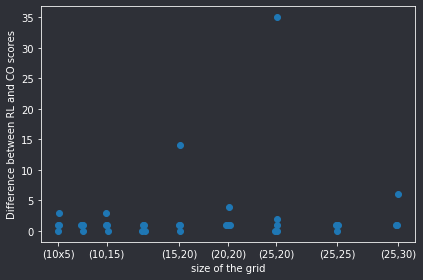

In [44]:
plt.rcParams['savefig.facecolor'] = (46/255., 48/255., 55/255.)
plt.rcParams['axes.facecolor'] = (46/255., 48/255., 55/255.)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.spines['bottom'].set_color("white")
ax.spines['top'].set_color("white") 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.title.set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
fig.set_facecolor((46/255., 48/255., 55/255.))
ax.set_facecolor((46/255., 48/255., 55/255.))


#plt.scatter(df[df.Type == 'CO']['Size of the grid'].values,df[df.Type == 'CO'].Time/3600,label = "CO")
#plt.scatter(df[df.Type == 'RL']['Size of the grid'],df[df.Type == 'RL'].Time/3600, label = "RL")
sizes_jitter = [np.random.normal(x, 2,1) for x in sizes]
plt.scatter(sizes_jitter,diff)
plt.xlabel("size of the grid")

x1 = [50,150,15*20,400,500,25*25,25*30]
squad = ['(10x5)','(10,15)','(15,20)','(20,20)','(25,20)','(25,25)','(25,30)']

ax.set_xticks(x1)
ax.set_xticklabels(squad)

plt.ylabel("Difference between RL and CO scores")

#l = plt.legend()
#for text in l.get_texts():
#    text.set_color("white")



ax = plt.gca()
plt.tight_layout()
plt.savefig("../data/processed/comparison_score.png", dpi = 300)

In [ ]:
df_20_agents = pd.read_csv("../data/processed/results_20_agents.csv",index_col = 'Unnamed: 0')

In [ ]:
df_10_agents = pd.read_csv("../data/processed/results_10_agents.csv",index_col = 'Unnamed: 0')

In [ ]:
df_4_agents = pd.read_csv("../data/processed/results_4_agents.csv",index_col = 'Unnamed: 0')

In [ ]:
plt.rcParams['savefig.facecolor'] = (46/255., 48/255., 55/255.)
plt.rcParams['axes.facecolor'] = (46/255., 48/255., 55/255.)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.spines['bottom'].set_color("white")
ax.spines['top'].set_color("white") 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.title.set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
fig.set_facecolor((46/255., 48/255., 55/255.))
ax.set_facecolor((46/255., 48/255., 55/255.))


plt.scatter(df_4_agents['Size of the grid'],df_4_agents['Time'].values/60, label = "4 trains",alpha= 0.8)
plt.scatter(df_10_agents['Size of the grid'],df_10_agents['Time'].values/60, label = "10 trains",alpha = 0.8)
plt.scatter(df_20_agents['Size of the grid'],df_20_agents['Time'].values/60, label = "20 trains",alpha = 0.8)


plt.xlabel("size of the grid (number of cells)")

x1 = [20**2,40**2,50*50,60*60]
squad = ['(20x20)','(40x40)','(50,50)','(60x60)']

ax.set_xticks(x1)
ax.set_xticklabels(squad)

plt.ylabel("time until solution (min)")
#plt.title("Experiment of multicommodity flow formulation until memory error (model > 40 Gb)")

l = plt.legend()
for text in l.get_texts():
    text.set_color("white")



ax = plt.gca()
plt.tight_layout()
plt.savefig("../data/processed/time.png", dpi = 300)